In [1]:
import re
import datetime
import time
import pandas as pd
import matplotlib as plt
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import *

In [2]:
import pickle

# カレントディレクトリにあるモデルデータの読み込み
gbm = pickle.load(open('アジ_lgbm.pkl', 'rb'))

In [ ]:
#!brew install graphviz


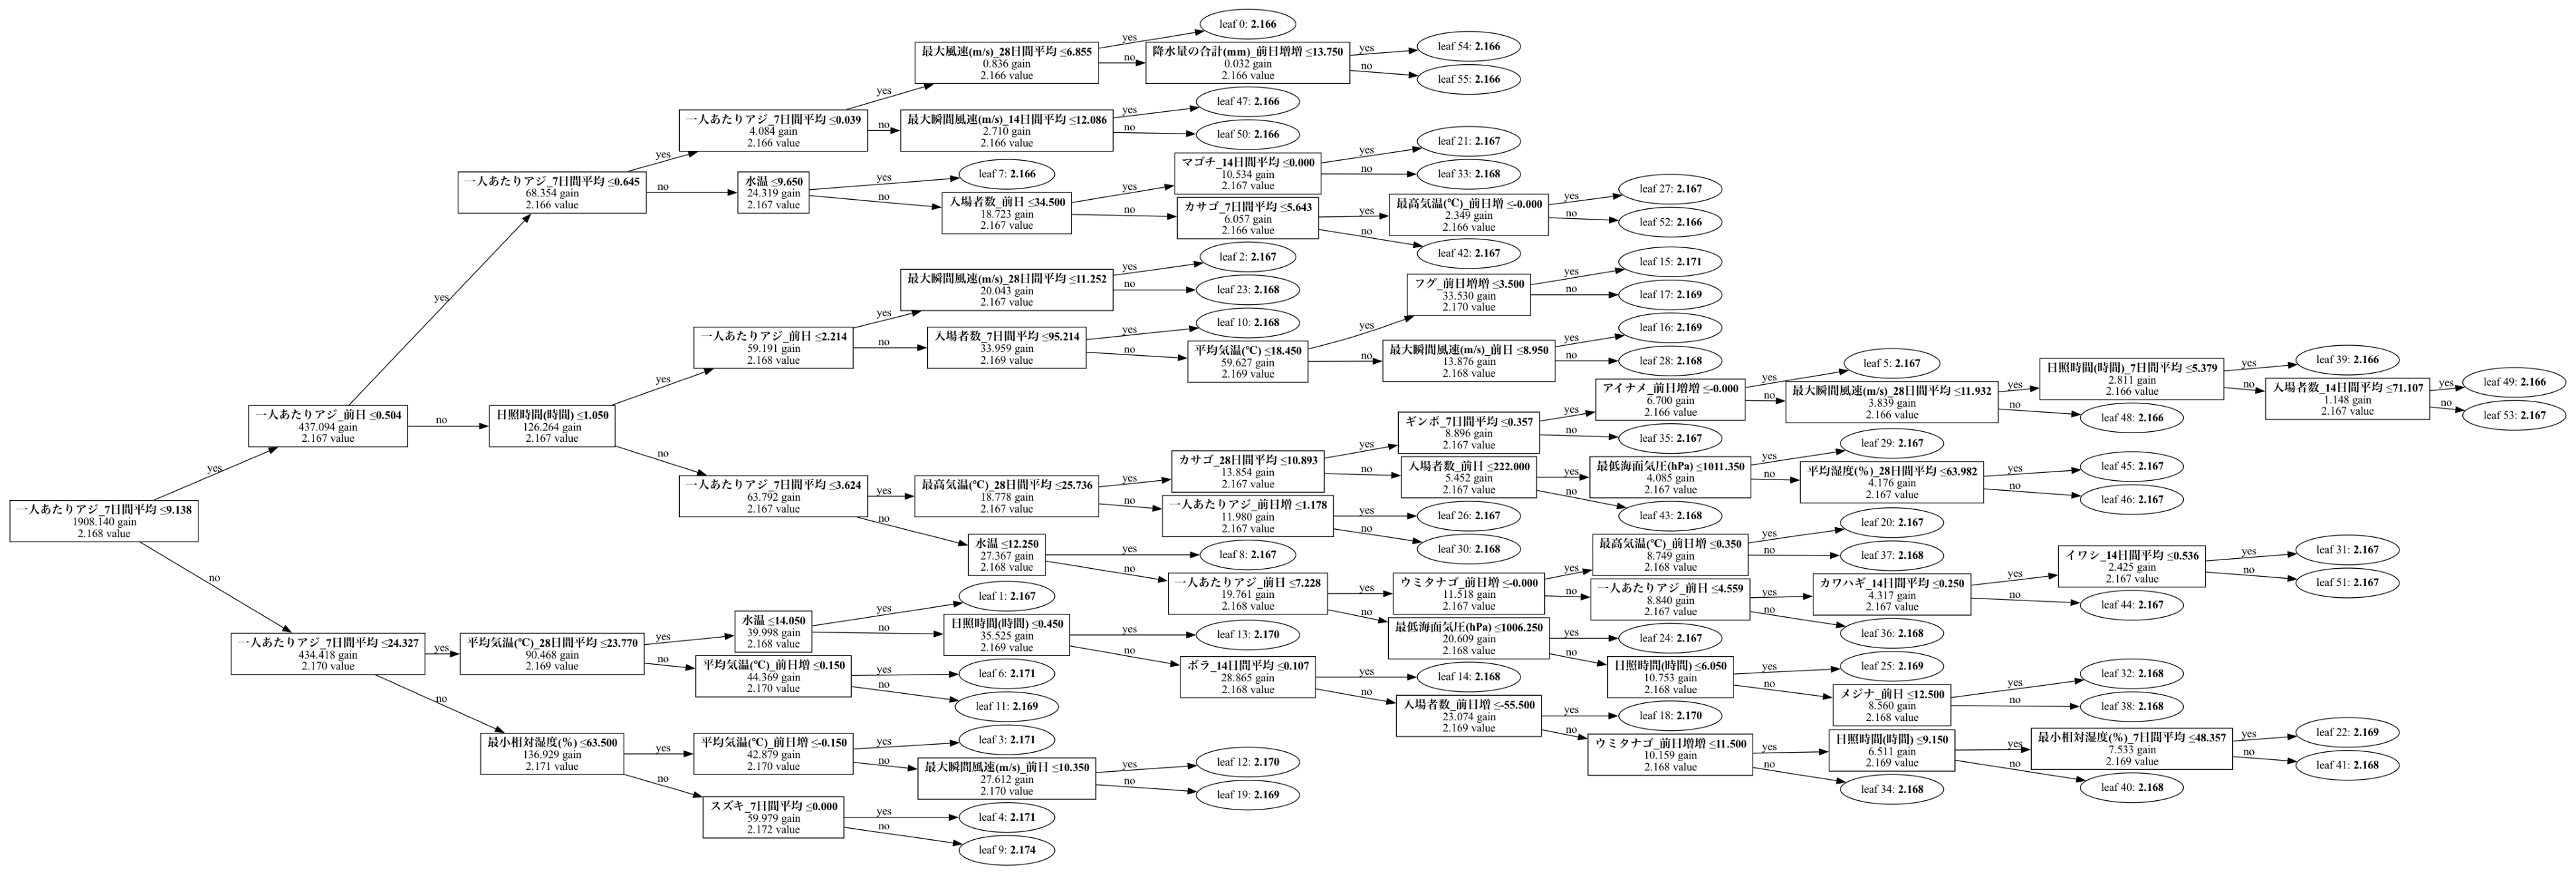

In [6]:
from graphviz import Digraph
dg = Digraph()
dg.attr('node', fontname="IPAGothic")

ax = lgb.plot_tree(gbm, tree_index=0, figsize=(50, 50), show_info=['split_gain', 'internal_value'])
plt.show()

In [7]:
df1 = pd.read_csv("アジ_df.csv")

In [ ]:
df1

In [9]:
aji = gbm.dump_model()

In [10]:
len(aji)

14

In [ ]:
aji.keys()

In [12]:
aji["objective"]

'regression sqrt'

In [ ]:
aji["tree_info"][0]

In [ ]:
aji["tree_info"][2]["tree_structure"]["left_child"]["left_child"]["left_child"]

In [14]:
aji["average_output"]

False

In [ ]:
aji["tree_info"][0]["tree_structure"].keys()

In [16]:
aji["tree_info"][0]["tree_index"]

0

In [17]:
model = aji
import copy
# 葉であれば value を返し、分岐であれば条件を追加し接続して葉まで辿る
# 葉に至るまで条件は　AND
# 最後の葉で function を add する
def parse_child(tree, query_param, conditions, result):
  if "split_index" in tree.keys():
    # 枝の場合
    # この分岐で検査される属性
    feature = model["feature_names"][tree["split_feature"]]
    # この分岐で検査される属性がクエリに入っているかどうか
    if feature in query_param.keys():
      # 比較を実施する
      # 比較オペレータが"<="の場合
      if tree["decision_type"] == "<=":
        if query_param[feature] <= tree["threshold"]:
          # left_child だけが生き残る
          parse_child(tree["left_child"], query_param, copy.copy(conditions), result)
        else:
          # right_child だけが生き残る
          parse_child(tree["right_child"], query_param, copy.copy(conditions), result)
      else:
        # "<=" 以外の decision type はエラーにする
        raise ValueError("Unsupported decision type: " + tree["decision_type"])
    else:
    # この分岐で検査される属性がクエリに入っていないとき
    # この分岐の条件を文字列化する
      if tree["decision_type"] == "<=":
        # 左側 true
        true_condtion = copy.copy(conditions)
        true_condtion.append({"feature_name": feature, "operator" : "<=" ,  "threshold": tree["threshold"]})
        parse_child(tree["left_child"], query_param, true_condtion, result)
        # 右側 false
        false_condition = copy.copy(conditions)
        false_condition.append({"feature_name": feature, "operator" : ">" ,  "threshold": tree["threshold"]})
        parse_child(tree["right_child"], query_param, false_condition, result)
      else:
        # "<=" 以外の decision type はエラーにする
        raise ValueError("Unsupported decision type: " + tree["decision_type"])
  else:
    # 葉の場合
    if abs(tree["leaf_value"]) > 0.001:
      result.append({"conditions": conditions, "leaf_value": tree["leaf_value"]})

# res = [resullt, result,...]
# result = {"condtions": [{"feature_name": feature1, "operator": "<=",  "threshold": val1}, ...], "leaf_value": leaf_value1}
# query_param = {"feature_name1": value1, "feature_name1": value2,...}
def functions(query_param):
  res = []
  for tree_info in model["tree_info"]:
    result = []
    conditions = []
    parse_child(tree_info["tree_structure"], query_param, conditions, result)
    if len(result) > 0:
      res.append(result)
  return res

In [19]:
# ある一日のデータを使って predict する
query_df = df1[df1["年月日"] == "2021-07-04"]
y_pred = gbm.predict(query_df.drop(["年月日", "一人あたりアジ"], axis=1), num_iteration=gbm.best_iteration)
# 予測値
print(y_pred)
query_param = query_df.to_dict(orient='records')[0]
# 正解データ
print(query_param["一人あたりアジ"])
del query_param["年月日"], query_param["一人あたりアジ"]

[14.35464309]
23.38235294117647


In [ ]:
# ある一日のデータをそのまま入れて、function を取得し、leaf_valueを足し合わせる

#query_param = {"一人あたりアジ_前日": query_param["一人あたりアジ_前日"], "水温": query_param["水温"], "一人あたりアジ_前日増" : query_param["一人あたりアジ_前日増"]}
print(query_param)
res = 0.0
for x in functions(query_param=query_param):
  for y in x:
    res = res + y["leaf_value"]
# mse を使っているので答えは 2乗する
print(res*res)

In [ ]:
# ある一日のデータの値を抽出してfunction を取得して出力する

query_param = {"一人あたりアジ_前日": query_param["一人あたりアジ_前日"], "水温": query_param["水温"], "一人あたりアジ_前日増" : query_param["一人あたりアジ_前日増"], "最大瞬間風速(m/s)": query_param["最大瞬間風速(m/s)"], "ベラ_前日": query_param["ベラ_前日"]}
print(query_param)

r = functions(query_param=query_param)
print(len(r))
for w in r:
  print(w)


In [ ]:
# 一個目のツリーだけ使った場合の予測値がどうなるか見ておく

In [22]:
query_df = df1[df1["年月日"] == "2021-08-05"]
y_pred = gbm.predict(query_df.drop(["年月日", "一人あたりアジ"], axis=1), num_iteration=1)
print(y_pred)
query_param = query_df.to_dict(orient='records')[0]
print(query_param["一人あたりアジ"])
del query_param["年月日"], query_param["一人あたりアジ"]

[4.69604069]
1.6153846153846154


In [23]:
query_df = df1[df1["年月日"] == "2021-08-06"]
y_pred = gbm.predict(query_df.drop(["年月日", "一人あたりアジ"], axis=1), num_iteration=1)
print(y_pred)
query_param = query_df.to_dict(orient='records')[0]
print(query_param["一人あたりアジ"])
del query_param["年月日"], query_param["一人あたりアジ"]

[4.69604069]
1.4925373134328357


In [24]:
query_df = df1[df1["年月日"] == "2021-08-07"]
y_pred = gbm.predict(query_df.drop(["年月日", "一人あたりアジ"], axis=1), num_iteration=1)
print(y_pred)
query_param = query_df.to_dict(orient='records')[0]
print(query_param["一人あたりアジ"])
del query_param["年月日"], query_param["一人あたりアジ"]

[4.69602236]
2.328767123287671


In [ ]:
query_df = df1[df1["年月日"] == "2021-08-08"]
y_pred = gbm.predict(query_df.drop(["年月日", "一人あたりアジ"], axis=1), num_iteration=1)
print(y_pred)
query_param = query_df.to_dict(orient='records')[0]
print(query_param["一人あたりアジ"])
del query_param["年月日"], query_param["一人あたりアジ"]

[54.65779469]
8.0
